In [23]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns
import math
from __future__ import division
sns.set_style('whitegrid')

In [24]:
# Import NCDC dataset
ipath= "6581206807038dat.txt"
uipath = unicode(ipath , "utf8")
file2 = open(uipath)
df = pd.read_csv(uipath,header=0, skipinitialspace=True)
df.drop(['USAF', 'NCDC', 'I','QCP','Q','Q.1','I.1','Unnamed: 12'], 1,inplace=True)
df.rename(columns={'Date':'date','Dir': 'dir', 'Spd':'speed'}, inplace=True)
df.describe()

,date,HrMn,dir,speed
count,853335.000000,853335.000000,853335.000000,853335.000000
mean,19922155.097373,1163.599446,296.597628,3.815579
std,128228.968011,691.447205,323.742323,18.270134
min,19650801.000000,0.000000,9.000000,0.000000
25%,19820629.000000,600.000000,80.000000,1.500000
50%,19900223.000000,1200.000000,190.000000,3.100000
75%,20041118.000000,1750.000000,290.000000,5.100000
max,20150801.000000,2358.000000,999.000000,999.900000


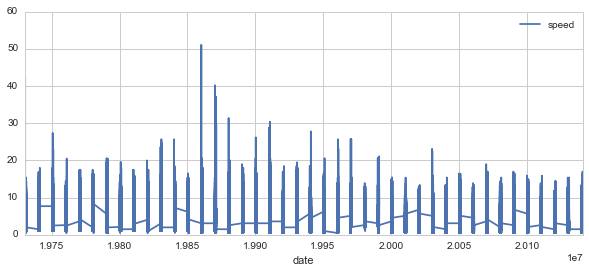

In [25]:
# Select year 1945-2014, dir < 999, speed<999
df = df[(df['dir'] < 999) & (df['speed'] < 999)& (df['date'] > 19720000) &(df['date'] < 20150000) ]
df.rename(columns={'speed':'speed_mps'}, inplace=True)
df['speed']=df['speed_mps']
df.index= df['date']
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

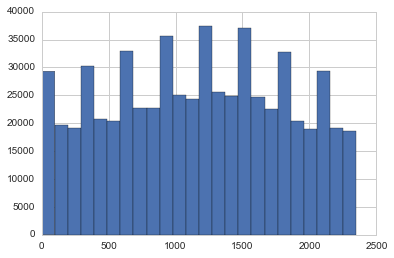

In [26]:
# Check time sample distribution,
# and found that its not equally sampled.
time = df[df['HrMn'] % 10 <= 0.1]
time['HrMn'].hist(bins = 24)

0    113902
9    113370
1       353
8         9
4         7
7         6
3         6
6         4
5         3
2         3
dtype: int64
9    249110
0    132996
8     76857
1      3284
7       192
6        91
5        29
4        23
3         5
2         4
dtype: int64


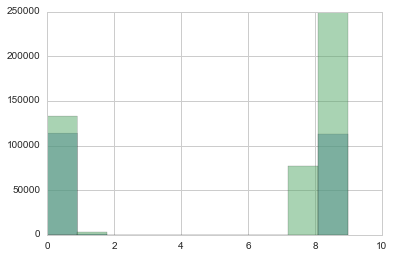

In [27]:
df['artifact'] = False

# Simple artifact detection
# 1. dir error
df.ix[df['dir'] % 10 >=0.1,'artifact']=True

# 2. Speed remain error
# Generate the first digit of fractional part of the speed(after convert to knot unit)
# e.g. 48.5 -> 5
import math
df['speed']=df['speed_mps']*1.943845
df['speed_remain'] = df['speed'].apply(lambda x: math.modf(x*10 % 10)[1])

# Plot the distribution of speed_remain,
# and compare between year<2000 and > 2000
temp = df[(df['date'] > 20000000)]
temp['speed_remain'].hist(bins = 10,alpha=0.5)
print temp['speed_remain'].value_counts()

temp = df[(df['date'] < 20000000)]
temp['speed_remain'].hist(bins = 10,alpha=0.5)
print temp['speed_remain'].value_counts()

In [28]:
# From the distribution above, 
# we can know that the legit number are only 0 and 9, all others are too rare to be normal.
df.ix[(df['speed_remain'] >= 2)&(df['speed_remain'] <= 7),'artifact']=True
df.drop(['speed_remain'], 1,inplace=True)
# and then converted the speed into integer
df.rename(columns={'speed':'speed_flt'}, inplace=True)
df['speed'] =  df['speed_flt'].apply(lambda x: int(round(x)))
df[df['artifact']== True].head(20)

,date,HrMn,Type,dir,speed_mps,speed_flt,artifact,speed
date,,,,,,,,
19820101,19820101,0,FM-12,120,4,7.775380,True,8
19820101,19820101,300,FM-12,140,8,15.550760,True,16
19820101,19820101,900,FM-12,150,6,11.663070,True,12
19820101,19820101,1200,FM-12,160,9,17.494605,True,17
19820101,19820101,1500,FM-12,240,10,19.438450,True,19
19820102,19820102,0,FM-12,260,12,23.326140,True,23
19820102,19820102,300,FM-12,340,8,15.550760,True,16
19820102,19820102,600,FM-12,310,6,11.663070,True,12
19820102,19820102,900,FM-12,340,4,7.775380,True,8


,date,HrMn,Type,dir,speed_mps,speed_flt,artifact,speed,incre,incre_reverse
date,,,,,,,,,,
19860207,19860207,1350,FM-15,220,51.0,99.136095,False,99,94,0
19860207,19860207,1400,FM-15,220,51.0,99.136095,False,99,0,82
19730416,19730416,1820,FM-15,40,42.7,83.002182,False,83,76,1
19730416,19730416,1850,FM-15,40,42.2,82.030259,False,82,-1,79
19870220,19870220,1407,FM-15,260,40.2,78.142569,False,78,0,58
19870220,19870220,1350,FM-15,260,40.2,78.142569,False,78,68,0
19871104,19871104,2120,FM-15,20,37.1,72.116650,False,72,59,0
19871104,19871104,2208,FM-15,20,37.1,72.116650,False,72,0,60
19880310,19880310,600,FM-12,330,31.4,61.036733,False,61,47,47


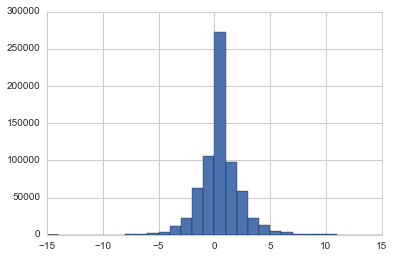

In [29]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0)
bins=np.arange(-15, 15 + 1, 1)
df['incre'].hist(bins=bins)
df.sort('speed',ascending=False).head(30)

In [30]:
# 3. Artifact detection: sudden increase
# detect udden increase from nearby data, consider singular increase
artifact = df[((df['incre'] > 20)&(df['incre_reverse'] > 20))]
df.ix[((df['incre'] > 20)&(df['incre_reverse'] > 20)),'artifact']=True
print len(artifact)
artifact

38


,date,HrMn,Type,dir,speed_mps,speed_flt,artifact,speed,incre,incre_reverse
date,,,,,,,,,,
19750703,19750703,1500,FM-12,290,27.3,53.066969,False,53,39,38
19751012,19751012,0,FM-12,180,14.9,28.963291,False,29,23,24
19751016,19751016,420,FM-15,200,20.5,39.848823,False,40,27,22
19761012,19761012,1420,FM-15,160,20.5,39.848823,False,40,26,28
19790414,19790414,1500,FM-12,260,20.6,40.043207,False,40,32,33
19800804,19800804,600,SY-MT,100,19.6,38.099362,False,38,35,31
19830806,19830806,1300,FM-15,230,25.7,49.956817,False,50,35,38
19830918,19830918,1200,FM-12,20,24.7,48.012971,False,48,38,38
19840104,19840104,912,FM-15,220,25.7,49.956817,False,50,32,32


In [31]:
### Summary of artifacts, which belongs to FM-15
# 3 types are handled:
# 1. Sudden increase in speed, e.g. 5, 50, 5. the 50 is detected
# 2. Strange wind direction record, e.g. 61, 78, 127, since wind dir are setcored into 10 degree
# 3. Speed not near an integer after converting back to knot, e.g. 23.4, 7.75

artifact = df[(df['artifact']==True)&(df['Type']=='FM-15')]
print len(artifact)
artifact

57


,date,HrMn,Type,dir,speed_mps,speed_flt,artifact,speed,incre,incre_reverse
date,,,,,,,,,,
19751016,19751016,420,FM-15,200,20.5,39.848823,True,40,27,22
19761012,19761012,1420,FM-15,160,20.5,39.848823,True,40,26,28
19830806,19830806,1300,FM-15,230,25.7,49.956817,True,50,35,38
19840104,19840104,912,FM-15,220,25.7,49.956817,True,50,32,32
19860718,19860718,120,FM-15,40,20.6,40.043207,True,40,37,37
19870903,19870903,1415,FM-15,260,27.8,54.038891,True,54,40,39
19901016,19901016,2020,FM-15,310,16.0,31.101520,True,31,24,25
19910705,19910705,1726,FM-15,280,30.4,59.092888,True,59,42,44
19920906,19920906,10,FM-15,61,1.0,1.943845,True,2,-1,-3
